In [1]:
import pandas as pd
import statsmodels.stats.api as sms
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro, levene, mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import ttest_ind

In [2]:
#### Load dataset
data = pd.read_csv('ab_data.csv')
data.head()

,user_id,timestamp,group,landing_page,converted
0,851104,11:48.6,control,old_page,0
1,804228,01:45.2,control,old_page,0
2,661590,55:06.2,treatment,new_page,0
3,853541,28:03.1,treatment,new_page,0
4,864975,52:26.2,control,old_page,1


In [3]:
#### Check format
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294480 entries, 0 to 294479
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294480 non-null  int64 
 1   timestamp     294480 non-null  object
 2   group         294480 non-null  object
 3   landing_page  294480 non-null  object
 4   converted     294480 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [4]:
#### Check values
for x in data.columns:
    print(x)
    print(data[x].values)

user_id
[851104 804228 661590 ... 715931 759899 643532]
timestamp
['11:48.6' '01:45.2' '55:06.2' ... '40:24.5' '20:29.0' '40:24.5']
group
['control' 'control' 'treatment' ... 'treatment' 'treatment' 'treatment']
landing_page
['old_page' 'old_page' 'new_page' ... 'new_page' 'new_page' 'new_page']
converted
[0 0 0 ... 0 0 0]


In [5]:
#### Check unique values
data.apply(lambda x: x.nunique())

user_id         290585
timestamp        35993
group                2
landing_page         2
converted            2
dtype: int64

In [6]:
#### Check null
data.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

In [7]:
#### Remove duplicates
print(data.shape)
df = data.drop_duplicates(subset = 'user_id', keep = False)
print(df.shape)

(294480, 5)
(286690, 5)


In [8]:
df[['group', 'landing_page']].value_counts()

group      landing_page
treatment  new_page        143397
control    old_page        143293
Name: count, dtype: int64

In [9]:
#### Check Mismatch-group & landing page
df_mismatch = df[(df["group"]=="treatment")&(df["landing_page"]=="old_page")
                |(df["group"]=="control")&(df["landing_page"]=="new_page")]
n_mismatch = df_mismatch.shape[0]
print(f"The number of mismatched rows:{n_mismatch} rows")
print("Percent of mismatched rows:%.2f%%" % (n_mismatch/df.shape[0]*100))

The number of mismatched rows:0 rows
Percent of mismatched rows:0.00%


In [10]:
#### Function to convert MM:SS.S to total seconds
def convert_to_seconds(timestamp):
    if pd.isnull(timestamp):
        return None
    minutes, seconds = map(float, timestamp.split(':'))
    return minutes * 60 + seconds

df['total_seconds'] = df ['timestamp'].apply(convert_to_seconds)

print(df)

        user_id timestamp      group landing_page  converted  total_seconds
0        851104   11:48.6    control     old_page          0          708.6
1        804228   01:45.2    control     old_page          0          105.2
2        661590   55:06.2  treatment     new_page          0         3306.2
3        853541   28:03.1  treatment     new_page          0         1683.1
4        864975   52:26.2    control     old_page          1         3146.2
...         ...       ...        ...          ...        ...            ...
294474   945152   51:57.1    control     old_page          0         3117.1
294475   734608   45:03.4    control     old_page          0         2703.4
294476   697314   20:29.0    control     old_page          0         1229.0
294477   715931   40:24.5  treatment     new_page          0         2424.5
294479   643532   40:24.5  treatment     new_page          0         2424.5

[286690 rows x 6 columns]


C:\Users\wkdal\AppData\Local\Temp\ipykernel_25880\840223902.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['total_seconds'] = df ['timestamp'].apply(convert_to_seconds)


In [11]:
#### Missing Value
df['total_seconds'] = df['total_seconds'].fillna(0)

C:\Users\wkdal\AppData\Local\Temp\ipykernel_25880\524388838.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['total_seconds'] = df['total_seconds'].fillna(0)


In [12]:
df.columns

Index(['user_id', 'timestamp', 'group', 'landing_page', 'converted',
       'total_seconds'],
      dtype='object')

In [13]:
df.describe()

,user_id,converted,total_seconds
count,286690.000000,286690.000000,286690.000000
mean,788036.057184,0.119450,1803.054213
std,91239.396095,0.324317,1038.167339
min,630000.000000,0.000000,0.000000
25%,709036.250000,0.000000,904.825000
50%,788059.500000,0.000000,1803.000000
75%,866998.750000,0.000000,2701.900000
max,945999.000000,1.000000,3599.900000


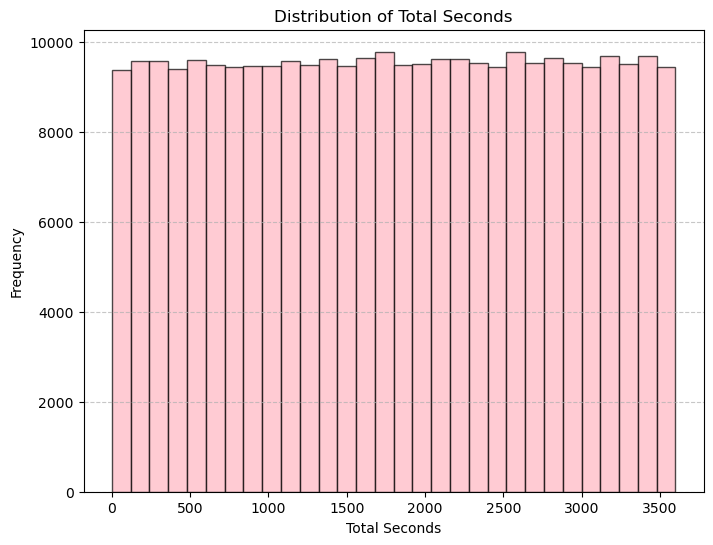

In [14]:
#### Plot the distribution of total seconds
plt.figure(figsize = (8,6))
plt.hist(df['total_seconds'], bins = 30, alpha = 0.7, color = 'lightpink', edgecolor = 'black')
plt.title('Distribution of Total Seconds')
plt.xlabel('Total Seconds')
plt.ylabel('Frequency')
plt.ylim(bottom = 0)
plt.grid(axis = 'y', linestyle = '--', alpha = 0.7)
plt.show()

In [15]:
#### AB Test
#### STEP1: 실험 목표 정의
#### 기본 측정항목: 전환율
#### 보조 지표: 페이지에서 보낸 시간

In [16]:
#### STEP2: 그룹 이해
#### 그룹 분포

In [17]:
group_counts = df['group'].value_counts()
group_ratios = group_counts / group_counts.sum()
print(group_ratios)

group
treatment    0.500181
control      0.499819
Name: count, dtype: float64


In [18]:
df.groupby(['group', 'landing_page']).agg({'landing_page': lambda x: x.value_counts()})

,,landing_page
group,landing_page,
control,old_page,143293
treatment,new_page,143397


In [19]:
df.groupby(['group', 'landing_page']).agg({'landing_page': lambda x: x.value_counts()/group_counts.sum()})

,,landing_page
group,landing_page,
control,old_page,0.499819
treatment,new_page,0.500181


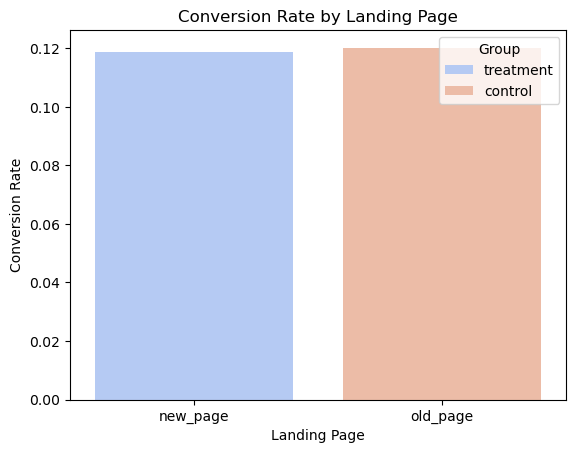

In [20]:
page_conversion = df.groupby(['landing_page', 'group'])['converted'].mean().reset_index()

# Plot

sns.barplot(data = page_conversion, x = 'landing_page', y = 'converted', hue = 'group', palette = 'coolwarm')
plt.title('Conversion Rate by Landing Page')
plt.ylabel('Conversion Rate')
plt.xlabel('Landing Page')
plt.legend(title = 'Group')
plt.show()

In [21]:
df.groupby(['group', 'landing_page']).agg({'converted': 'mean'})

,,converted
group,landing_page,
control,old_page,0.120173
treatment,new_page,0.118726


In [22]:
conversion_summary = df.groupby('group')['converted'].mean().reset_index()
conversion_summary.columns = ['Group', 'Conversion Rate']

print(conversion_summary)

       Group  Conversion Rate
0    control         0.120173
1  treatment         0.118726


C:\Users\wkdal\AppData\Local\Temp\ipykernel_25880\3995786204.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = conversion_summary, x = 'Group', y = 'Conversion Rate', palette = 'viridis')


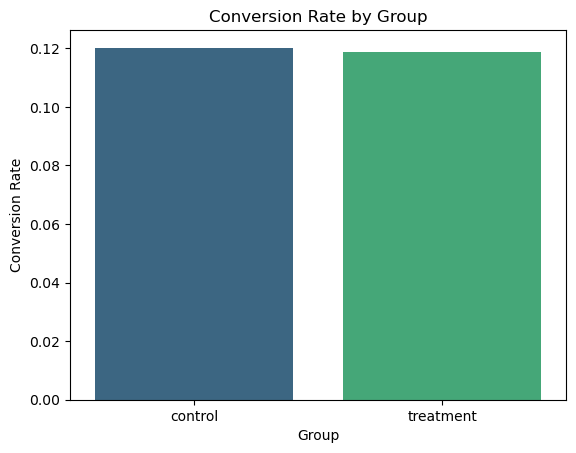

In [23]:
sns.barplot(data = conversion_summary, x = 'Group', y = 'Conversion Rate', palette = 'viridis')
plt.title('Conversion Rate by Group')
plt.ylabel('Conversion Rate')
plt.xlabel('Group')
plt.show()

In [24]:
#### STEP3:가설 세우기
#### H0:pA = pB (Null Hypothesis); 그룹 간 전환율에는 차이가 없습니다; 이전 페이지(old page)와 새 페이지(new page) 간에 통계적으로 유의미한 차이가 없습니다.
#### H1:pA ≠ pB (Alternative Hypothesis); Treatment group은 전환율(conversion rate)이 더 높습니다.; 이전 페이지(old page)와 새 페이지(new page) 간에 통계적으로 유의미한 차이가 있습니다.

In [25]:
#### STEP4: 지표 분석

In [26]:
#### A: 전환율
conversion_rates = df.groupby('group')['converted'].mean()
print(conversion_rates)

group
control      0.120173
treatment    0.118726
Name: converted, dtype: float64


In [27]:
#### B: 페이지에서 머문 시간
time_metrics = df.groupby('group')['total_seconds'].mean()
print(time_metrics)

group
control      1804.832314
treatment    1801.277402
Name: total_seconds, dtype: float64


In [28]:
#### STEP5: 통계 검정
#### two proportion z-Test: 두 그룹의 비율을 비교 검정하기 위해 활용

In [29]:
#### A. Test- 전환율
control = df[df['group'] == 'control']['converted']
treatment = df[df['group'] == 'treatment']['converted']

control_converted = control.sum()
treatment_converted = treatment.sum()

# Size of group
n_control = len(control)
n_treatment = len(treatment)

stat, p_value = proportions_ztest([control_converted, treatment_converted], [n_control, n_treatment])
print(f"Z-test Statistic: {stat}, p-value:, {p_value:.6f}")

Z-test Statistic: 1.1944850812796501, p-value:, 0.232288


In [30]:
#### B. Test- 페이지에 머문 시간
control_time = df[df['group'] == 'control']['total_seconds']
treatment_time = df[df['group'] == 'treatment']['total_seconds']

t_stat, p_value = ttest_ind(control_time, treatment_time)
print(f"T-test Statistic: {t_stat}, p-value: {p_value:.6f}")

T-test Statistic: 0.9167220080609694, p-value: 0.359289
